In [1]:
%reload_ext autoreload
%autoreload 2

# Basic python imports
import os, sys, time, logging, powerbox
import numpy as np

# The LambdaCDM cosmology
from astropy.cosmology import Planck18 as cosmo

# Import modified 21cmFAST
import py21cmfast as p21c
from py21cmfast import cache_tools
from py21cmfast import plotting

# Configure environment for use with DarkHistory # use branch test_dm21cm
#os.environ['DH_DIR']='/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/DarkHistory/'
sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum

# Import DM21CM code for this project
sys.path.append("..")
import dm21cm.physics as phys
from dm21cm.utils import split_xray, get_z_edges, gen_injection_boxes, p21_step
from dm21cm.dm_params import DMParams
from dm21cm.dh_wrapper import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.data_cacher import Cacher
from dm21cm.data_loader import load_dict

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")
#mpl.rcParams['text.usetex']=False

# Logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('21cmFAST').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)
logging.info(f'Using 21cmFAST version {p21c.__version__}')

/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702


# Configure the 21cmFAST

In [2]:
run_name = 'test'
p21c.config['direc'] = os.environ['P21C_CACHE_DIR'] + '/' + run_name
os.makedirs(p21c.config['direc'], exist_ok=True)
#cache_tools.clear_cache()

# The range of times and how we step
z_start = 45.
z_end = 5.
z_step_factor = 1.01

# The size and resolution of our box
box_dim = 64 # [Dimensionless]
box_len = box_dim * 2. # [Mpccm]

In [3]:
p21c.global_params.Z_HEAT_MAX = z_start
p21c.global_params.ZPRIME_STEP_FACTOR = z_step_factor
p21c.global_params.CLUMPING_FACTOR = 1.

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = box_dim,
        BOX_LEN = box_len,
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = cosmo.Om(0),
        OMb = cosmo.Ob(0),
        POWER_INDEX = cosmo.meta['n'],
        SIGMA_8 = cosmo.meta['sigma8'],
        hlittle = cosmo.h,
    ),
    random_seed = 54321,
    write = True,
)

/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


## Configure

In [4]:
dh_tf_version = '230629'

abscs = load_dict(f'../data/abscissas/abscs_{dh_tf_version}.h5')
tf_prefix = f"{os.environ['DM21CM_DATA_DIR']}/tf/{dh_tf_version}"

ex_lo, ex_hi = 1e2, 1e4 # [eV]
ix_lo = np.searchsorted(abscs['photE'], ex_lo) # i of first bin greater than ex_lo, excluded
ix_hi = np.searchsorted(abscs['photE'], ex_hi) # i of first bin greater than ex_hi, included

xray_fn = p21c.config['direc']+'/xray_brightness.h5'
if os.path.isfile(xray_fn):
    os.remove(xray_fn)
    
cacher = Cacher(data_path=xray_fn, cosmo=cosmo, N=box_dim, dx=box_len/box_dim)

# Our energy injection model
dm_params = DMParams(
    mode='swave',
    primary='phot_delta',
    abscs=abscs,
    m_DM=1e10,
    sigmav=1e-23,
    struct_boost_model='erfc 1e-3',
)

dh_wrapper = DarkHistoryWrapper(
    dm_params,
    prefix=p21c.config[f'direc'],
)

In [5]:
dh_wrapper.evolve(end_rs=(1+z_end)*0.9);

INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


In [10]:
tf_wrapper = TransferFunctionWrapper(
    box_dim = box_dim,
    abscs = abscs,
    tf_prefix = tf_prefix,
    enable_elec = False,
)

# Evolution

In [11]:
# Where we start looking for annuli
xray_loop_start = 0

# Some details regarding our stepping
z_edges = get_z_edges(z_start, z_end, 1.01)

def get_time_step(i_z):
    current_z = z_edges[i_z]
    next_z = z_edges[i_z+1]
    
    # The cosmic time step size in [s]
    dt = ( cosmo.age(next_z) - cosmo.age(current_z) ).to('s').value
    return current_z, next_z, dt

In [12]:
# Initial step with no injection
perturbed_field = p21c.perturb_field(redshift=z_edges[0], init_boxes=p21c_initial_conditions)
spin_temp, ionized_box, brightness_temp = p21_step(z_edges[0], perturbed_field, None, None)

# Match 21cmFAST with DarkHistory state
dh_wrapper.match(spin_temp, ionized_box)
phot_bath_spec = dh_wrapper.get_phot_bath(rs=1+spin_temp.redshift)

records = []

for i_z in range(len(z_edges)-1):

    timer_start = time.time()

    # Print some information about the step we are taking
    current_z, next_z, dt = get_time_step(i_z)

    print(f'step {i_z} z: {current_z:.3f}->{next_z:.3f} ', end='', flush=True)
    
    # Derived quantities that I need
    nBavg = phys.n_B * (1+current_z)**3 # [Bavg / (physical cm)^3]
    delta_plus_one_box = 1 + np.asarray(perturbed_field.density)
    rho_DM_box = delta_plus_one_box * phys.rho_DM * (1+current_z)**3 # [eV/(physical cm)^3]
    x_e_box = np.asarray(1 - ionized_box.xH_box) # check this
    inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * dm_params.struct_boost(1+current_z) / nBavg # [inj/Bavg]
    
    # Initialize the step for tf_wrapper
    tf_wrapper.init_step(
        rs = 1+ current_z,
        delta_plus_one_box = delta_plus_one_box,
        x_e_box = x_e_box,
    )
    
    #############################
    ###   Energy Deposition   ###
    #############################
        
    # Now calculate photon emission and energy deposition from our X-ray annuli
    for i_z_shell in range(xray_loop_start, i_z):
        
        # Load the cached data
        xray_brightness_box, xray_spec, is_box_average = cacher.get_annulus_data(
            current_z, z_edges[i_z_shell], z_edges[i_z_shell+1]
        )

        # If we are smoothing on the scale of the box then dump to the global bath spectrum.
        # The deposition will happen later, and we will not revisit this shell.
        if is_box_average:
            phot_bath_spec.N += xray_brightness_box[0, 0, 0] * xray_spec.N
            xray_loop_start = max(i_z_shell+1, xray_loop_start)
            continue

        tf_wrapper.inject_phot(xray_spec, inject_type='xray', weight_box=xray_brightness_box)

    print(f'xray: {time.time()-timer_start:.3f} ', end='', flush=True)
    timer_start = time.time()

    # Homogeneous bath injection
    tf_wrapper.inject_phot(phot_bath_spec, inject_type='bath')
    
    # DM on-the-spot injection
    tf_wrapper.inject_from_dm(dm_params, inj_per_Bavg_box)

    print(f'bath+dm: {time.time()-timer_start:.3f} ', end='', flush=True)
    timer_start = time.time()
    
    #############################################################
    ###   Generate the input boxes and take a 21cmFAST step   ###
    #############################################################
    
    perturbed_field = p21c.perturb_field(redshift=next_z, init_boxes=p21c_initial_conditions)    
    input_heating, input_ionization, input_jalpha = gen_injection_boxes(next_z, p21c_initial_conditions)
    tf_wrapper.populate_injection_boxes(input_heating, input_ionization, input_jalpha)
     
    spin_temp, ionized_box, brightness_temp = p21_step(
        next_z, perturbed_field, spin_temp, ionized_box,
        input_heating, input_ionization, input_jalpha
    )

    print(f'21cmfast: {time.time()-timer_start:.3f} ', end='', flush=True)
    timer_start = time.time()
    
    ########################################################
    ###   Prepare X-Ray and Bath Spectra for Next Step   ###
    ########################################################
    
    # Advance all cached spectra through this redshift step.        
    attenuation_arr = tf_wrapper.attenuation_arr(rs=1+current_z, x=np.mean(x_e_box))
    cacher.advance_spectrum(attenuation_arr, next_z)
    
    ################################################################
    ###   Cache X-Ray Emission from this Step and Prepare Bath   ###
    ################################################################

    prop_phot_N, emit_phot_N = tf_wrapper.prop_phot_N, tf_wrapper.emit_phot_N
    
    # Split the x-ray spectrum into bath and emission
    emit_bath_N, emit_xray_N = split_xray(emit_phot_N, ix_lo, ix_hi)
    out_phot_N = prop_phot_N + emit_bath_N
    
    # Prepare the bath spectrum for the next step    
    out_phot_spec = Spectrum(abscs['photE'], out_phot_N, rs=1+current_z, spec_type='N')
    out_phot_spec.redshift(1+next_z)
    phot_bath_spec = out_phot_spec
    
    # Redshift the x-ray spectrum to the next timestep. Then cache the brightness box and spectrum
    xray_spec = Spectrum(abscs['photE'], emit_xray_N, rs=1+current_z, spec_type='N') # [photon / Bavg]
    xray_spec.redshift(1+next_z)
    
    xray_e_box = tf_wrapper.xray_E_box / np.dot(abscs['photE'], emit_xray_N) # [1 (relative energy) / Bavg]
    cacher.set_cache(current_z, xray_e_box, xray_spec)
    
    #######################################################
    ###   Save some Global Quantities for Convenience   ###
    #######################################################
    
    dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box) # [eV per Bavg]
    dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / dm_params.struct_boost(1+current_z)

    record_inj = {
        'dE_inj_per_B' : dE_inj_per_Bavg,
        'f_ion'  : np.mean(tf_wrapper.dep_box[...,0] + tf_wrapper.dep_box[...,1]) / dE_inj_per_Bavg_unclustered,
        'f_exc'  : np.mean(tf_wrapper.dep_box[...,2]) / dE_inj_per_Bavg_unclustered,
        'f_heat' : np.mean(tf_wrapper.dep_box[...,3]) / dE_inj_per_Bavg_unclustered,
    }
    
    record = {
        'z'   : next_z,
        'T_s' : np.mean(spin_temp.Ts_box), # [mK]
        'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
        'T_k' : np.mean(spin_temp.Tk_box), # [K]
        'x_e' : np.mean(1 - ionized_box.xH_box), # [1]
        'E_phot' : phot_bath_spec.toteng(), # [eV/Bavg]
    }
    record.update(record_inj)
    records.append(record)
    #print(record['T_b'])
    
    #arr_records = {k: np.array([r[k] for r in records]) for k in records[0].keys()}
    #np.save('./New_Debug', arr_records)
    
    print(f'others: {time.time()-timer_start:.3f}')

step 0 z: 45.000->44.678 xray: 0.007 bath+dm: 3.167 21cmfast: 0.042 others: 0.033
step 1 z: 44.678->44.226 xray: 0.921 bath+dm: 2.013 21cmfast: 0.041 others: 0.036
step 2 z: 44.226->43.778 xray: 1.814 bath+dm: 2.013 21cmfast: 0.038 others: 0.034
step 3 z: 43.778->43.335 xray: 2.716 bath+dm: 1.999 21cmfast: 0.040 others: 0.035
step 4 z: 43.335->42.896 xray: 3.617 bath+dm: 1.975 21cmfast: 0.038 others: 0.034
step 5 z: 42.896->42.461 xray: 4.503 bath+dm: 2.006 21cmfast: 0.041 others: 0.036
step 6 z: 42.461->42.031 xray: 5.359 bath+dm: 1.990 21cmfast: 0.039 others: 0.034
step 7 z: 42.031->41.605 xray: 5.731 bath+dm: 1.975 21cmfast: 0.038 others: 0.041
step 8 z: 41.605->41.183 xray: 5.692 bath+dm: 2.000 21cmfast: 0.039 others: 0.035
step 9 z: 41.183->40.766 xray: 5.672 bath+dm: 1.988 21cmfast: 0.037 others: 0.034
step 10 z: 40.766->40.352 xray: 5.593 bath+dm: 2.000 21cmfast: 0.043 others: 0.035
step 11 z: 40.352->39.943 xray: 5.712 bath+dm: 2.003 21cmfast: 0.041 others: 0.039
step 12 z: 39.

In [22]:
import pickle
pickle.dump(records, open(f'records_{run_name}.p', 'wb'))

# Below we make Lightcones and Power Spectra

In [13]:
lightcone_quantities = (
    'brightness_temp', 'Ts_box', 'xH_box', 'dNrec_box', 'z_re_box',
    'Gamma12_box', 'J_21_LW_box', 'density'
)

In [ ]:
lightcone= p21c.run_lightcone(
    redshift = z_edges[-1],
    init_box = p21c_initial_conditions,
    flag_options = ionized_box.flag_options,
    astro_params = ionized_box.astro_params,
    lightcone_quantities = lightcone_quantities,
    global_quantities = lightcone_quantities,
    random_seed = 54321,
    direc = p21c.config['direc'],
)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
I

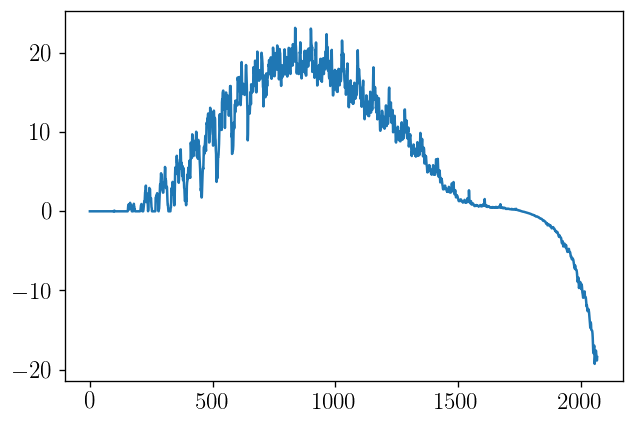

In [15]:
plt.plot(np.mean(lightcone.brightness_temp[0], axis = 0))

In [16]:
lightcone_redshifts = lightcone.lightcone_redshifts

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
I

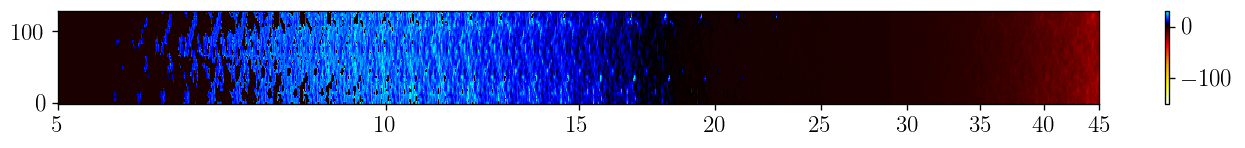

In [17]:
fig, ax = plt.subplots(figsize = (14, 1))

im = ax.pcolormesh(lightcone_redshifts, np.arange(cacher.N)*cacher.dx, 
              lightcone.brightness_temp[0], cmap = mpl.colormaps['EoR'], vmin = -150, vmax = 30)

ax.set_xscale('log')
ax.set_xticks([], minor = True)
ax.set_xlim(5, 45)

ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40, 45], minor = False)
ax.set_xticklabels(['5', '10', '15', '20', '25', '30', '35', '40', '45'], minor = False)

cax = plt.colorbar(im)
plt.show()


In [18]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = powerbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = list(range(0,brightness_temp.n_slices, int(np.floor(brightness_temp.n_slices / nchunks),)) )   
    print(chunk_indices)
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (box_len, box_len, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [19]:
k_fundamental = 2*np.pi/box_len
k_max = k_fundamental * box_dim
Nk = np.floor(box_dim).astype(int)

out = powerspectra(lightcone, min_k = k_fundamental, max_k = k_max)

[0, 103, 206, 309, 412, 515, 618, 721, 824, 927, 1030, 1133, 1236, 1339, 1442, 1545, 1648, 1751, 1854, 1957, 2060]


/n/home07/yitians/dm21cm/DM21cm/powerbox/src/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/dm21cm/DM21cm/powerbox/src/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
I

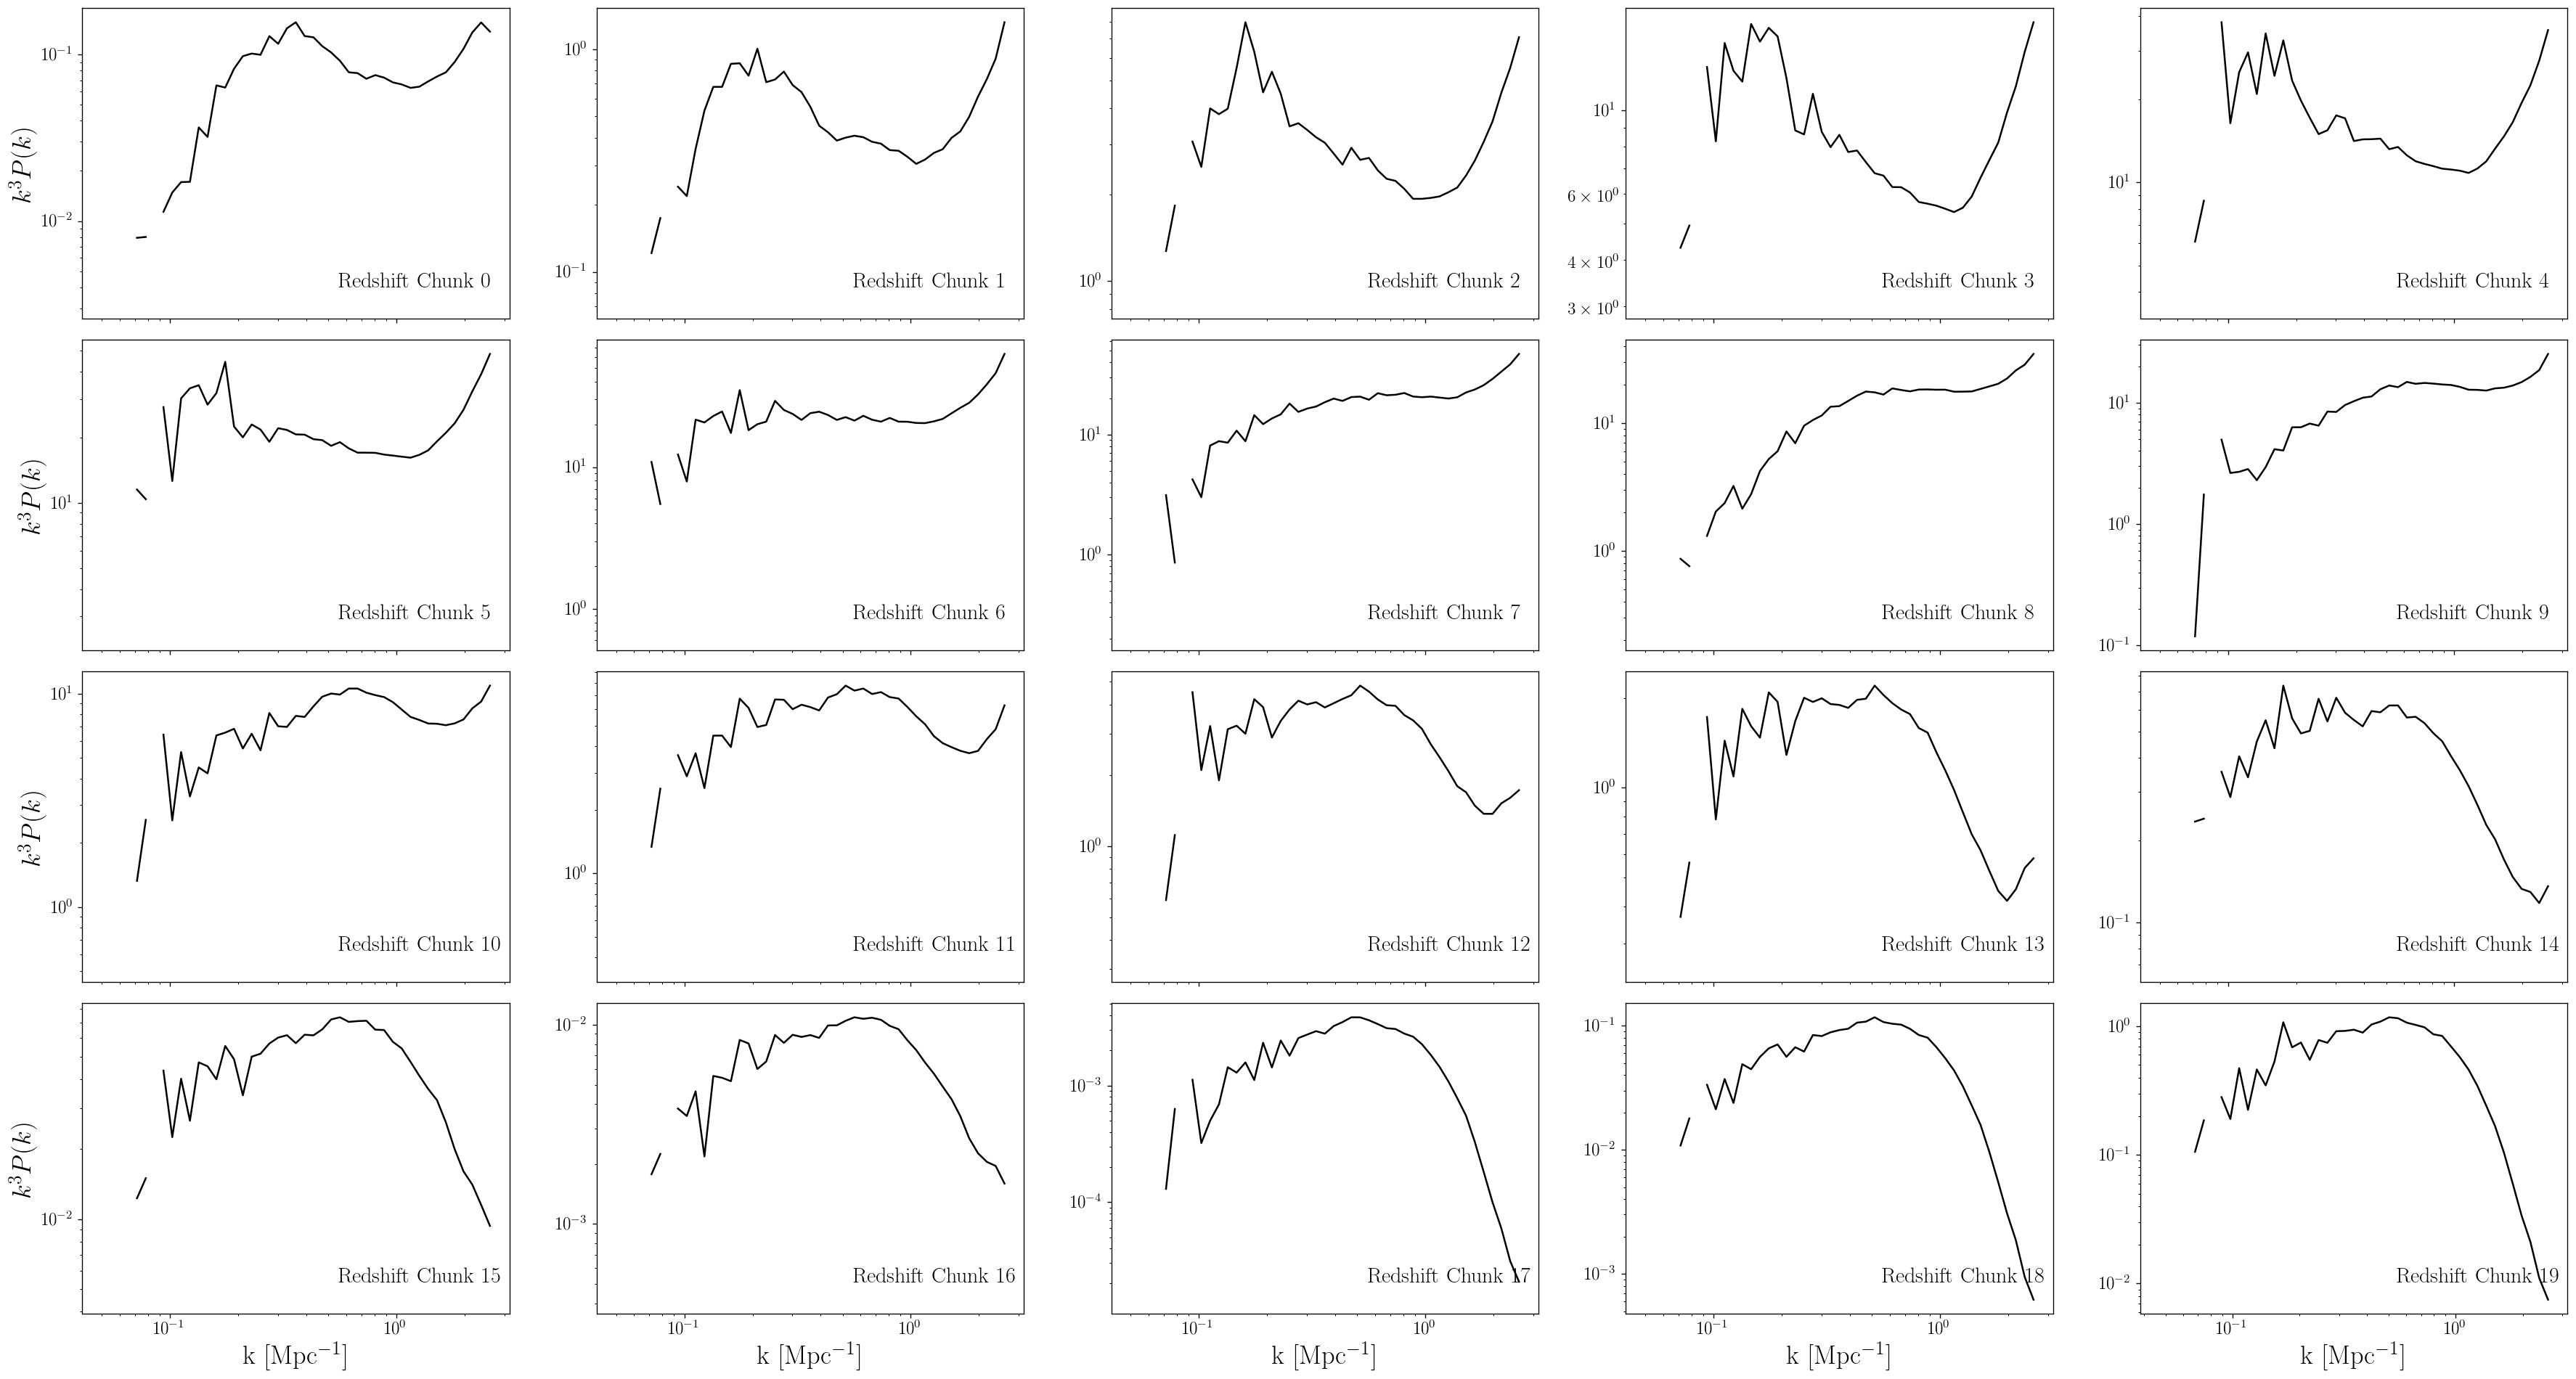

In [20]:
fig, axs = plt.subplots(ncols = 5, nrows = 4, figsize = (30, 16))

for i, item in enumerate(out):
    row_index, col_index = np.unravel_index(i, axs.shape)
    
    ax = axs[row_index, col_index]
    ax.plot(item['k'], item['delta'], color = 'black')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(.6, .1, 'Redshift Chunk ' + str(i), transform=ax.transAxes, fontsize = 18)
    
for i in range(axs.shape[0]-1):
    for j in range(axs.shape[1]):
        axs[i, j].set_xticklabels([])

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel('k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('$k^3 P(k)$', fontsize = 22)
    
plt.tight_layout()
plt.show()